#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Рассмотрите пример работы слоя `ConvTranspose2d`.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [81]:
import zipfile
import os

zip_file_path = "archive.zip"
extract_dir = "archive_ex"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(extract_dir)

In [82]:
import torch
import os

dataset_path = os.path.join("archive_ex")

image_dataset_path = os.path.join(dataset_path, "jpeg_images")
mask_dataset_path = os.path.join(dataset_path, "jpeg_masks")

test_split = 0.15

device = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if device == "cuda" else False

num_channels = 1
num_classes = 1
num_levels = 3
batch_size = 64


init_lr = 0.001
num_epochs = 40
threshold = 0.5
base_out = "output"

height = 128
width = 128

MODEL_PATH = os.path.join(base_out, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([base_out, "plot.png"])
TEST_PATHS = os.path.sep.join([base_out, "test_paths.txt"])



In [83]:
import cv2

class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self, imagePaths, maskPaths, transforms):
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transforms

  def __len__(self):
    return(len(self.imagePaths))

  def __getitem__(self, idx):
    imagePath = self.imagePaths[idx]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)

    if self.transforms:
      image = self.transforms(image)
      mask = self.transforms(mask)

    if isinstance(mask, torch.Tensor) and mask.ndim == 2:
        mask = mask.unsqueeze(0)

    return (image, mask)


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [84]:
import numpy as np

def show_image_with_mask(image, mask):

    if isinstance(image, torch.Tensor):
      image = image.permute(1, 2, 0).cpu().numpy()

    if isinstance(mask, torch.Tensor):
      if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)
      mask = mask.cpu().numpy()

    if image.dtype in [np.float32, np.float64]:
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


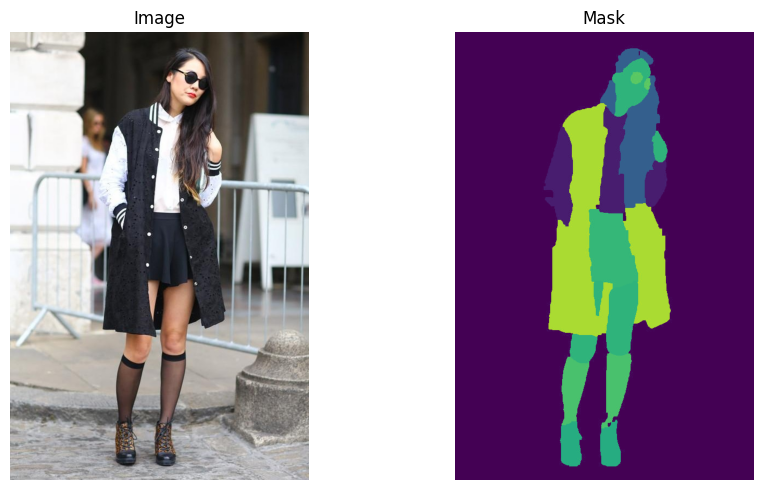

In [85]:
from imutils import paths
import matplotlib.pyplot as plt

imagePaths = sorted(list(paths.list_images(image_dataset_path)))
maskPaths = sorted(list(paths.list_images(mask_dataset_path)))


dataset = SegmentationDataset(imagePaths=imagePaths,
                               maskPaths=maskPaths,
                               transforms=None)

image, mask = dataset[0]

show_image_with_mask(image, mask)





<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [86]:
from torch import nn

class Block(nn.Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, 3)

  def forward(self, x):

    return self.conv2(self.relu(self.conv1(x)))

In [87]:
class Encoder(nn.Module):
  def __init__(self, channels=(3, 16, 32, 64)):
    super().__init__()
    self.encBlocks = nn.ModuleList(
        [Block(channels[i], channels[i + 1])
          for i in range(len(channels) - 1)]
    )
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    blockOutputs = []

    for block in self.encBlocks:
      x = block(x)
      blockOutputs.append(x)
      x = self.pool(x)
    return blockOutputs


In [88]:
from torchvision.transforms import CenterCrop

class Decoder(nn.Module):
  def __init__(self, channels=(64, 32, 16)):
    super().__init__()

    self.channels = channels
    self.upconvs = nn.ModuleList(
        [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
        for i in range(len(channels) - 1)])
    self.dec_blocks = nn.ModuleList(
        [Block(channels[i], channels[i + 1])
        for i in range(len(channels) - 1)])

  def forward(self, x, encFeatures):
    for i in range(len(self.channels) - 1):
      x = self.upconvs[i](x)
      encFeat = self.crop(encFeatures[i], x)
      x = torch.cat([x, encFeat], dim=1)
      x = self.dec_blocks[i](x)

    return x

  def crop(self, encFeatures, x):

    (_, _, H, W) = x.shape
    encFeatures = CenterCrop([H, W])(encFeatures)

    return encFeatures



In [89]:
from torch.nn import functional as F

class UNet(nn.Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
               decChannels=(64, 32, 16),
               nbClasses=1, retainDim=True,
               outSize=(height, width)):
    super().__init__()
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)

    self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize


  def forward(self, x):

    encFeatures = self.encoder(x)
    decFeatures = self.decoder(encFeatures[::-1][0],
                              encFeatures[::-1][1:])
    map = self.head(decFeatures)

    if self.retainDim:
      map = F.interpolate(map, self.outSize)

    return map



In [90]:
import numpy as np
import cv2

def count_unique_classes(maskPaths):
    unique_classes = set()
    for path in maskPaths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        unique_classes.update(np.unique(mask))
    return len(unique_classes)

n_classes = count_unique_classes(maskPaths)
print("Number of classes:", n_classes)


Number of classes: 66


In [91]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.ToTensor()
])

dataset = SegmentationDataset(
    imagePaths=imagePaths,
    maskPaths=maskPaths,
    transforms=transform
)



unet = UNet(nbClasses=n_classes, retainDim=True, outSize=(height, width)).to(device)
image, _ = dataset[0]

if image.ndim == 3:
    image = image.unsqueeze(0)

image = image.to(device)

unet.eval()
with torch.no_grad():
    output = unet(image)
print("Output shape:", output.shape)



Output shape: torch.Size([1, 66, 128, 128])


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [92]:
from sklearn.model_selection import train_test_split

imagePaths = sorted(list(paths.list_images(image_dataset_path)))
maskPaths = sorted(list(paths.list_images(mask_dataset_path)))

split = train_test_split(imagePaths, maskPaths,
                         test_size=test_split, random_state=42)

(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# f = open(TEST_PATHS, "w")
# f.write("\n".join(testImages))
# f.close()


In [93]:
from torchvision import transforms
from torch.utils.data import DataLoader

transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((height, width)),
                                 transforms.ToTensor()])


train_ds = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms)
test_ds = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)

print(f"train ds: {len(train_ds)}")
print(f"test ds: {len(test_ds)}")

trainLoader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, pin_memory=PIN_MEMORY, num_workers = os.cpu_count())
testLoader = DataLoader(test_ds, shuffle=False, batch_size=batch_size, pin_memory=PIN_MEMORY, num_workers = os.cpu_count())

train ds: 850
test ds: 150


In [94]:
# from torch.optim import Adam

# unet = UNet().to(device)
# loss = nn.BCEWithLogitsLoss()
# opt = Adam(unet.parameters(), lr=init_lr)
# train_steps = len(train_ds) // batch_size
# test_steps = len(test_ds) // batch_size


# H = {"train_loss": [], "test_loss": []}

In [95]:
from collections import Counter

def calculate_class_weights(maskPaths):
    class_counts = Counter()
    for path in maskPaths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())

    total_pixels = sum(class_counts.values())
    weights = [total_pixels / (n_classes * count) for count in class_counts.values()]
    return torch.tensor(weights, device=device)

weights = calculate_class_weights(maskPaths)
print(f"Class weights: {weights}")

Class weights: tensor([1.9889e-02, 3.2500e+00, 1.5212e+00, 8.5222e+00, 1.1249e+01, 1.9144e+01,
        8.8714e+00, 3.0317e+01, 1.5387e+00, 2.3516e+00, 3.7024e+01, 1.4996e+01,
        3.6690e+01, 5.7236e-01, 1.8133e+00, 4.4581e+01, 3.2078e+01, 3.4693e+00,
        1.2739e+01, 6.3766e-01, 6.2841e-01, 1.5388e+00, 3.5347e+00, 5.6125e+00,
        5.9088e+00, 1.9800e+00, 1.3136e+01, 1.9373e+01, 2.2068e+00, 2.1697e+00,
        3.7095e+01, 1.8251e+01, 1.5197e+00, 1.6592e+01, 2.6959e+00, 5.9318e+00,
        1.1098e+01, 6.0562e+01, 3.6593e+00, 9.7385e+00, 4.7052e+01, 1.1443e+01,
        3.8859e+00, 2.2777e+02, 6.5668e+00, 7.4932e+01, 5.7535e+01, 3.7348e+02,
        8.9032e+00, 9.6559e+03, 1.2753e+03, 3.4810e+03, 9.7207e+01, 1.6869e+01,
        7.3198e+01, 1.5278e+05, 5.5963e+00, 1.3874e+01, 2.6961e+04, 1.6719e+01,
        6.8088e-01, 3.9609e+01, 4.4378e+01, 2.0594e+01, 3.2738e+05, 6.8750e+06],
       device='cuda:0')


In [106]:
print("n_classes:", n_classes)
print("Class weights:", weights)


n_classes: 66
Class weights: tensor([1.9889e-02, 3.2500e+00, 1.5212e+00, 8.5222e+00, 1.1249e+01, 1.9144e+01,
        8.8714e+00, 3.0317e+01, 1.5387e+00, 2.3516e+00, 3.7024e+01, 1.4996e+01,
        3.6690e+01, 5.7236e-01, 1.8133e+00, 4.4581e+01, 3.2078e+01, 3.4693e+00,
        1.2739e+01, 6.3766e-01, 6.2841e-01, 1.5388e+00, 3.5347e+00, 5.6125e+00,
        5.9088e+00, 1.9800e+00, 1.3136e+01, 1.9373e+01, 2.2068e+00, 2.1697e+00,
        3.7095e+01, 1.8251e+01, 1.5197e+00, 1.6592e+01, 2.6959e+00, 5.9318e+00,
        1.1098e+01, 6.0562e+01, 3.6593e+00, 9.7385e+00, 4.7052e+01, 1.1443e+01,
        3.8859e+00, 2.2777e+02, 6.5668e+00, 7.4932e+01, 5.7535e+01, 3.7348e+02,
        8.9032e+00, 9.6559e+03, 1.2753e+03, 3.4810e+03, 9.7207e+01, 1.6869e+01,
        7.3198e+01, 1.5278e+05, 5.5963e+00, 1.3874e+01, 2.6961e+04, 1.6719e+01,
        6.8088e-01, 3.9609e+01, 4.4378e+01, 2.0594e+01, 3.2738e+05, 6.8750e+06],
       device='cuda:0')


In [96]:
unet = UNet(nbClasses=n_classes, retainDim=True, outSize=(height, width)).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
def calculate_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).sum().item()
    total = masks.numel()
    return correct / total

In [99]:
# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(unet.parameters(), lr=init_lr)

# Цикл обучения
for epoch in range(num_epochs):
    unet.train()
    train_loss, train_acc = 0.0, 0.0

    # Обучение
    for images, masks in tqdm(trainLoader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, masks = images.to(device), masks.squeeze(1).long().to(device)

        optimizer.zero_grad()
        outputs = unet(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, masks)

    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader)

    # Валидация
    unet.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images, masks in testLoader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)
            outputs = unet(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, masks)

    val_loss /= len(testLoader)
    val_acc /= len(testLoader)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1/40: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


Epoch 1: Train Loss = 2.4339, Train Acc = 0.7183, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 2/40: 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Epoch 2: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 3/40: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch 3: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 4/40: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 4: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 5/40: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


Epoch 5: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 6/40: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch 6: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 7/40: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch 7: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 8/40: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


Epoch 8: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 9/40: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 9: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 10/40: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Epoch 10: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 11/40: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch 11: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 12/40: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Epoch 12: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 13/40: 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Epoch 13: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 14/40: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 14: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 15/40: 100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


Epoch 15: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 16/40: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Epoch 16: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 17/40: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


Epoch 17: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 18/40: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Epoch 18: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 19/40: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


Epoch 19: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 20/40: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 20: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 21/40: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Epoch 21: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 22/40: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


Epoch 22: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 23/40: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Epoch 23: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 24/40: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


Epoch 24: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 25/40: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 25: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 26/40: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch 26: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 27/40: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]


Epoch 27: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 28/40: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 28: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 29/40: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


Epoch 29: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 30/40: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch 30: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 31/40: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 31: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 32/40: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch 32: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 33/40: 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]


Epoch 33: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 34/40: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch 34: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 35/40: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Epoch 35: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 36/40: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


Epoch 36: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 37/40: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch 37: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 38/40: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


Epoch 38: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 39/40: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 39: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


Epoch 40/40: 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


Epoch 40: Train Loss = 0.0000, Train Acc = 1.0000, Val Loss = 0.0000, Val Acc = 1.0000


<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре